# GS 102 Survey Data Analysis

### Professor Tiffany Page 

In this notebook, we will learn how to analyze survey data. Using the cleaned data from the last notebook, you will practice manipulating data tables, creating data visualizations, and interpreting results. You will also be introduced to basic concepts in statistical inference.


*Estimated Time: 2 hours*

--------------------------------------------------------------------------------------------------------------------------------

# Table of Contents 

1. <a href = '#section0'>The Data</a>


2. <a href = '#section1'>Part I: Relationship between Demographic Factors and Presidential Choice</a>


3. <a href = '#section2'>Part II: Significance Tests for Categorical Variables</a>

    a. <a href = '#subsection2a'>Hypothesis Testing: The Basics</a>
    
    b. <a href = '#subsection2b'>The Chi-square Test: A Case Study</a>
    
    c. <a href = '#subsection2c'>Correlation vs. Causation</a>
    
    
4. <a href = '#section3'>Part III: Relationship between Demographic Factors and Ease of Voting</a>


5. <a href = '#section4'>Part IV: Relationship between Political Ideology and Positions on Campus Political Climate</a>


6. <a href = '#section5'>Part V: Analyzing Text Responses</a>


7. <a href = '#section6'>Part VI: Bias in Surveys</a>


8. <a href = '#section7'>Bibliography</a>

# Topics Covered
 - Pivot Tables
 - Bar Charts 
 - Significance Tests and Chi-Square Goodness of Fit
 - Correlation vs. Causation
 - Bias in Survey Data

##### Dependencies: (Run the cell below before continuing)

In [1]:
from datascience import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set()

### The Data <a id = 'section0'></a>

You'll be working with data collected from a survey about the voting patterns of students at UC Berkeley. This data was collected by Hannah Hill, a student who used the data to study the factors that influence youth voter turnout. In this notebook, we will analyze the cleaned data from the last notebook and interpret the results. Here's a peek at the first few rows of our dataset:

In [24]:
data = Table().read_table('clean_survey.csv')
data.show(3)

Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14
2,1,4,3,18,climate change,1,2,1,1,1,1,5
3,3,4,2,18,immigration,1,3,3,2,1,7,6
2,3,4,2,18,Climate change,1,6,2,1,1,7,6


Let's start by looking at the relationships between demographic factors (eg. Major, Gender Identity, and Ethnicity) and candidate of choice in the 2016 Presidential Election.

### Part I: Relationship between Demographic Factors and Presidential Choice <a id = 'section1'></a>

#### Exercise 1.1: Displaying Rows

Let's get an idea of the data we're working with. 

Run the next two cells to see the number of columns and the number of rows in the data set.

In [25]:
data.num_rows

300

In [26]:
data.num_columns

13

#### Exercise 1.3: Pivot Tables

Pivot tables (also known as Contingency Tables) are data structures that allow us to summarize key points in our dataset. In our case, we are trying to look at the relationship between Major and Presidential Vote. Our *independent variable*, or the variable that we believe influences the other, is Major. This variable should be presented along the columns of our pivot table. The *dependent variable* should be placed along the rows of the pivot table. The data within the table will be counts of Major-President pairs.

**TASK:** Use the `Table` method `.pivot` to create a pivot table between Major and Presidential Vote. This method takes in two arguments: the *column name* to be displayed along the columns, and the *column name* to be displayed along the rows. Save the resulting pivot table into a name called `pivoted_major_presidential_votes`.

In [29]:
pivoted_data = data.pivot('Q5', 'Q8')
pivoted_data

Q8,1.0,2.0,3.0
1,7,74,102
2,2,4,11
3,0,3,2
4,1,3,2
5,1,0,0
6,1,0,6
7,5,23,25
8,2,13,13


Let's understand what's happening here. Within the first column, we have the three possibilities for presidential votes. Along the rest of the columns, we have the possibilities for major choice. The values in the 2nd column onwards are the counts of Major-President pairs within our dataset. For example, there were 34 people who *both* voted for Hillary Clinton and majored in Arts & Humanities.

**Question:** Is this pivot table enough information to make conclusions about Major and Presidential Choice? Why or why not? 

**Answer:** [Click on this cell and write your answer here]

We need to convert the counts in the pivot table to proportions to make a fair comparison between Majors.

**TASK:** Use the function `counts_to_proportions` to convert the pivot table into another pivot table with proportions. This function takes in a pivot table and returns a modified pivot table. Save the result into a name called `proportion_major_vote`.

In [30]:
pivoted_proportions = counts_to_proportions(pivoted_data)
pivoted_proportions

Q8,1.0,2.0,3.0
1,0.368421,0.616667,0.63354
2,0.105263,0.0333333,0.068323
3,0,0.025,0.0124224
4,0.0526316,0.025,0.0124224
5,0.0526316,0,0
6,0.0526316,0,0.0372671
7,0.263158,0.191667,0.15528
8,0.105263,0.108333,0.0807453


Awesome job! We're almost ready to start making inferences. The last step is to visualize our data. 

#### Exercise 1.4: Bar Charts

Our goal is to visualize the proportion of students who voted for each presidential candidate on a chart. We can use *bar charts* to do this. According to Wikipedia, a *bar chart* is a data visualization which "presents categorical data with rectangular bars with heights or lengths proportional to the values that they represent."

Before we delve into analysis, let's look at a simple application of bar charts: How are Majors distributed within our dataset?

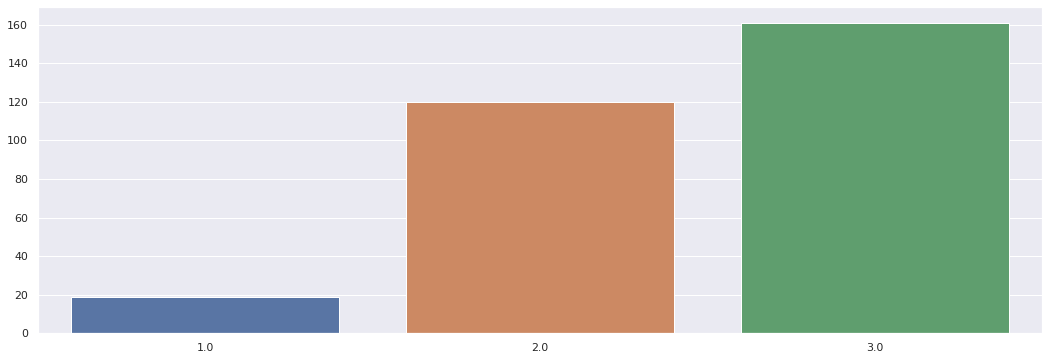

In [32]:
plt.figure(figsize = (18, 6))
plt.rcParams.update({'font.size': 15})
sns.barplot(x = data.group('Q5').column('Q5'), y = data.group('Q5').column('count')); # Run this cell


**Question:** What does this bar chart tell us about the distribution of majors within our dataset? Do you think this dataset is representative of the total student population?

**Answer:** [Click on this cell and write your answer here]

**TASK:** Use the `plot_bar_chart` function to visualize the proportions of votes of Business Majors for each presidential candidate. This function takes in 4 arguments. First, enter the relevant pivot table. Next, enter a list containing the column name(s) you want to visualize. Additionally, enter a title for the chart. Finally, enter the variable of comparison.

In [ ]:
plot_bar_chart(pivoted_proportions, ['Business'], 'Proportion of Votes for each Presidential Candidate', 'Major')


**TASK:** Next, use the `plot_bar_chart` method to visualize the proportions of votes made among all majors. 

In [ ]:
plot_bar_chart(pivoted_proportions, ['Arts & Humanities', 'Business', 'Engineering/Computer Science', 'Life Sciences',
                'Physical Sciences/Mathematics', 'Social Sciences'], 
               'Proportion of Votes for each Presidential Candidate by Major', 'Major')
plt.xlabel("Presidential Choice");

**Question:** What majors tend to have similar voting patterns? Are there any differences that stand out? Why do you think this may be the case?

**Answer:** [Click on this cell and write your answer here]

### Recap

We've covered quite a bit so far. Let's summarize what we've covered so far:

1. Filtering Rows for Missing Values and Improper Formatting


2. Re-structuring the dataset into Pivot Tables


3. Creating Bar Charts to visualize the relationship between categorical variables


4. Interpreting visualizations

#### Exercise 1.5: Processing Pipeline

In data science, when you repeat a set of tasks to analyze a dataset, you are creating a *data processing pipeline*. 

We've now analyzed the relationship between a student's major and their choice of Presidential candidate. Let's extend our analysis to Gender Identity and Ethnicity as well. 

**TASK:** Write a function that takes in a table, two column names of categorical variables in the table, a title, and a category, and outputs a bar graph displaying the relationship between those variables. The first column name is the independent variable.

**Hint:** This question requires you to follow the steps that we took before and apply them in a more general way. 

In [37]:
def categorical_variable_relationship(table, first, second, title, category):
    table = table.select([first, second])
    table = drop_missing_rows(table, first)
    table = drop_missing_rows(table, second)
    pivot = table.pivot(first, second)
    proportion_pivot = counts_to_proportions(pivot)
    plot_bar_chart(proportion_pivot, proportion_pivot.labels[1:], title, category)

**TASK:** Using your newly created `categorical_variable_relationship` function, plot a bar chart to find the relationship between Gender Identity **'Q7'** and Presidential vote **'Q17'**. Interpret the chart and write your findings below. 

In [ ]:
categorical_variable_relationship(data,
'Q7', 'Q17', 'Relationship between Gender Identity and Presidential Vote',
                                  'Gender Identity')
plt.xlabel("Presidential Choice");

**Answer:** [Click on this cell and write your answer here]

**TASK**: Using your newly created `categorical_variable_relationship` function, plot a bar chart to find the relationship between Ethnic/Racial Identity **'Q8'** and Presidential vote **'Q17'**. Interpret the chart and write your findings below.

In [ ]:
categorical_variable_relationship(data,
                                  'Q8', 'Q17', 'Relationship between Ethnic Identity and Presidential Vote',
                                  "Ethnic/Racial Identity")
plt.xlabel("Presidential Choice");

**Answer:** [Click on this cell and write your answer here]

### Part II: Significance Tests for Categorical Variables <a id = 'section2'></a>

So far, we've created pivot tables between categorical variables and plotted bar charts to compare distributions. Based on these charts, we were able to come up with *qualitative differences* between variables. For example, we can say that, based on the bar chart of student majors, there isn't an *even/equal* distribution of majors within our sample. We know this because some majors had much higher counts than the others (*potentially overrepresented*). 






However, how do we know that these differences are not due to *random chance* alone? To answer this question, we turn to **hypothesis testing** for categorical variables. 

### Hypothesis Testing: The Basics <a id = 'subsection2a'></a>

Hypothesis tests are used when you observe some phenomena and want to know whether it happened by random chance alone or due to a specific cause. A *hypothesis* is an guess about the world, based on available evidence. We want to *test* between two different hypotheses:

- The **Null** Hypothesis: My observation has arisen due to **random chance alone**. 


- The **Alternative** Hypothesis: My observation has arisen due to a cause **other** than random chance alone. 

Ex: I flip a coin 100 times and get 99 heads. I want to conduct a hypothesis test to check whether the coin is fair or not. What should my null and alternative hypothesis be?

### Step 1: Pivoting the Data

**TASK:** Use the `Table` method `.pivot` with the appropriate ordering of column names to generate the pivot table shown earlier. Save this into a name called `party_by_gender`. 

Don't worry about the ordering of values; just make sure to have the correct values on the vertical and horizontal axis. 

In [ ]:
party_by_gender = voting.pivot("Party", "Gender")
party_by_gender

### Step 2: Adding Row and Column Totals

In order to calculate the expected counts under our null hypothesis of independence, we need to calculate row and column totals.

**Row totals** are horizontal sums added as the right-most column of the table. In this case, they would represent the total number of females and males in the dataset. 

**Column Totals** are vertical sums added as the bottom row of the table. In our example, they represent the total number of Democrats and Republicans. 

**TASK:** Create a table called `totals` which adds a Row Total and Column Total to the `party_by_gender` table. Use the function `add_row_totals`, which takes in a pivot table and returns an updated version with the row totals. Also use the function `add_column_totals`, which takes in a pivot table and returns an updated version with the column totals. 

In [ ]:
totals = add_row_totals(party_by_gender)
totals = add_column_totals(totals)
totals

In [ ]:
chisquaretest(totals)

You may have noticed that there is another output called the **p-value**. This is a number which indicates the likelihood that your observations are consistent with the null hypothesis. In this case, our null hypothesis is that party choice and gender are independent of each other. 

By convention, we say that:
- If the p-value is less than or equal to 0.05 then, we can reject the null hypothesis. Essentially, what we are saying here is that a 1 in 20 chance of observing our test statistic is too unlikely for the null hypothesis to be true.
- If the p-value is greater than 0.05, then we do not reject the null hypothesis.

Rejecting the null hypothesis means that we have evidence that supports the alternative hypothesis. In the case of Chi-square tests, it means that the two variables are inter-related. In either case, notice that *we never accept* that a hypothesis is true; *rather, we simply reject or fail to reject it.* 

**TASK:** Based on our p-value, what can we determine about the relationship between gender and party choice? What can you say about the null hypothesis?

**Answer:** [Click on this cell and write your answer here]

Now, let's apply what we've learned to our dataset. 

**Task:** Using the `major_presidential_vote` table, let's run a Chi-square test. Write down the null hypothesis. Calculate the chi-square statistic and the corresponding p-value. Interpret the result. Should we *reject or fail to reject the null hypothesis?*

*Null Hypothesis:* [Click on this cell and write your answer here]

*Alternative Hypothesis:* [Click on this cell and write your answer here]

In [ ]:
cleaned_data = drop_missing_rows(major_presidential_vote, 'Q17').pivot('Q5', 'Q17')
cleaned_data = add_row_totals(cleaned_data)
cleaned_data = add_column_totals(cleaned_data)
chisquaretest(cleaned_data)

**Answer:** [Click on this cell and write your answer here]

### Discussion: Correlation vs. Causation <a id = 'subsection2c'></a>

In any class involving statistics, you may have heard the adage, *"Correlation doesn't imply causation."* 

Let's clarify what that means and why it's so important. *Correlation* is the inter-relation in trends of two variables (ex: gender and political party). Whereas, *Causation* is an explicit statement that a change in one variable directly incites a change in the other variable (ex: smoking and respiratory illness). 


Let's look at some concrete examples of why correlation isn't the same as causation. For instance, there is a 95.8% correlation between the per capita consumption of mozzarella cheese and the number of Civil Engineering doctorates awarded in the US. Clearly, these are two completely unrelated events that aren't linked to one another. As such, we wouldn't use this correlation as evidence of causality between these variables. 

For more "Spurious Correlations", check out this link: https://www.tylervigen.com/spurious-correlations


In our discussion of Chi-square tests, we were able to find that the relationship between certain variables (ie. major and presidential voting choice) deviated significantly from the null hypothesis. Does this mean that major *causes* the choice in presidential candidates? No. To establish that relationship, we must gather more evidence.

Typically, to establish a causal relationship between variables, you must perform a randomized controlled experiment. If you're interested in this topic, you can check out this link for more information: https://www.statisticssolutions.com/establishing-cause-and-effect/



### Part III: Relationship between Demographic Factors and Ease of Voting <a id = 'section3'></a>

#### Exercise 3.1: Understanding the Data

Let's take a look at the column representing the difficulty/ease of voting. 

**TASK:** Use table method `.select` to display the relevant column. If there are many missing values, use the `drop_missing_rows` function to get a better look at the data.

In [ ]:
drop_missing_rows(data.select('Q29_1'), 'Q29_1')

**Question:** What do you observed about the data? Are we working with numbers? How will this affect the way we go about analyzing the data?

**Answer:** [Click on this cell and write your answer here]

#### Exercise 3.2: Plotting Ordinal Data

Since these are responses on a Likert scale, they cannot be manipulated and operated on like regular numerical data. For instance, it doesn't make sense to take the *average* of *Extremely Easy* and *Slighly Difficult*. At the end of the day, Likert scale responses are opinions, so they fundamentally are categorical variables. Thus, techniques that you learned before still apply. 

**TASK:** In the cell below, plot the relationship between **Major ('Q5')** and **Ease of Voter Registration ('Q29_1')**. Interpret the visualization. Do the same for **Gender Identity ('Q7')** and **Ethnic Identity ('Q8')**.

In [ ]:
categorical_variable_relationship(data, 'Q5', 'Q29_1', 'Relationship between Major and Ease of Voter Registration', 'Major')
plt.xlabel("Ease of Voter Registration");

**Answer:** [Click on this cell and write your answer here.]

In [ ]:
categorical_variable_relationship(data, 'Q7', 'Q29_1', 'Relationship between Gender Identity and Ease of Voter Registration', 'Gender Identity')
plt.xlabel("Ease of Voter Registration");

**Answer:** [Click on this cell and write your answer here.]

In [ ]:
categorical_variable_relationship(data, 'Q8', 'Q29_1', 'Relationship between Ethnic Identity and Ease of Voter Registration', 'Ethnic/Racial Identity')
plt.xlabel("Ease of Voter Registration");

**Answer:** [Click on this cell and write your answer here.]

### Part IV: Relationship between Political Ideology and Positions on Campus Political Climate <a id = 'section4'></a>

#### Exercise 4.1: Understanding the Data

Lastly, we'll look at the relationship between political ideology and campus political climate. 

**TASK:** As before, display the relevant columns of the data table with the `.select` method. Make sure to remove missing data in each column with `drop_missing_rows`.

In [ ]:
ideology_vs_climate = drop_missing_rows(drop_missing_rows(data.select(['Q41_23', 'Q40_1']), 'Q41_23'), 'Q40_1')
ideology_vs_climate

**TASK:** Plot the relationship between political ideology and feelings about political discourse on campus. Write your observations below.

In [ ]:
categorical_variable_relationship(ideology_vs_climate, 'Q41_23', 'Q40_1', 'Relationship between Political Ideology and Feelings about Political Discourse on Campus', 'Political Ideology')
plt.xlabel("Feeling about Political Discourse on Campus");

**Answer:** [Click on this cell and write your response here]

### Part V: Analyzing Text Responses <a id = 'section5'></a>

So far, we've been dealing with survey data in the form of multiple choice questions or rankings. However, sometimes in a survey, you want to ask responders to enter text or multple responses for their answer. One example of this is the column **'Q20'** which is about the responder's reaction to the result of the 2016 election.

#### Exercise 5.1: Word Clouds

To deal with data in the form of text, we can use word cloud. These data visualizations are commonly used when you want to display the most frequently occuring words in a piece of text. They work by counting the number of occurences of each word in a set of text, and then display each word proportionally to its frequency. Thus, more frequent words look bigger and vice versa. 

**TASK:** Create a wordcloud for the column **"Q23_5_TEXT"** using the `create_wordcloud` function, which takes in a table name and a column name containing text data. Write your observations below. 

In [39]:
q15 = Table.read_table("survey.csv").select("Q15")
q15_clean = drop_missing_rows(q15, "Q15")

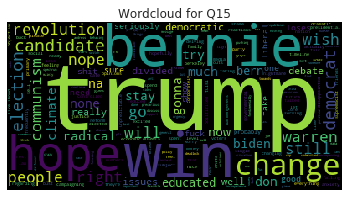

In [41]:
create_wordcloud(q15_clean, 'Q15')

**Answer**: [Click on this cell and write your answer here]

### Part VI: Bias in Surveys <a id = 'section6'></a>

The goal of a survey is to provide information about a large population from a limited sample. In this notebook, we've gone quite in depth in how to analyze different variables present in a survey. However, we've operated under the assumption that our survey data was representative of the UC Berkeley student population. However, in the real world, data collection is messy and difficult. Thus, we must be aware of sources of bias that may be present in our data. Here are a few common sources of bias in survey data:

- **Undercoverage bias**: Certain groups of the population are left out of the sample, leading to an *undercoverage* of responses in the sample


- **Nonresponse bias**: If the survey is optional, then certain respondants may not complete it. This may lead to skewed data. 


- **Self-selection bias**: If sample members volunteer themselves to take the survey, it may be the case that they are passionate about the issues asked about. This usually leads to an over-representation of individuals with strong opinions in the survey.


**TASK:** Given these sources of bias, do you see any problems with the methodology of the Hill survey? If there are problems, what could you do to fix them? 


**Answer:** [Click on this cell and write your answer here]

--------------------------------------------------------------------------------------------------------------------------------

## Bibliography <a id = 'section7'></a>

• Caitlin Light - Adapted Chi-square case study. https://www.ling.upenn.edu/~clight/chisquared.htm

• Tyler Vigen - Incorporated example of "spurious" correlation. https://www.tylervigen.com/spurious-correlations

• Statistics Solutions - Referenced section on experimental design. https://www.statisticssolutions.com/establishing-cause-and-effect/

• Stat Trek - Adapted material on sources of survey bias. https://stattrek.com/survey-research/survey-bias.aspx

___
### Getting extra help

Interested in more help with learning Python or computational survey analysis? Check out  [Data Peer Consulting](https://data.berkeley.edu/education/data-peer-consulting) in Moffitt library for drop-in, one-on-one questions. For additional workshops designed for people new to computational analysis, take a look at the workshops at [The Dlab](https://dlab.berkeley.edu) (free for Berkeley students!). 

Good luck!

------------------------------------------------------------------------------------------------------------------------

### Feedback:
Please let us know your thoughts on this notebook!

Fill out the survey at this link: https://docs.google.com/forms/d/e/1FAIpQLSfahkYSKqlEEfC6WMKlaqeIxRVj0r7T4N5lgBf9bRVwRG58wQ/viewform

#### Note to Students: 
If you would like to use the utility provided by the Data Science Education Program team, simply copy the utils.py script to the folder where you are creating your analysis notebook. Good luck!

------------------------------------------------------------------------------------------------------------------------
Notebook developed by: Ritvik Iyer, Jiaqi (Arianna) Guo, Monica Wilkinson

Data Science Modules: http://data.berkeley.edu/education/modules